# Лабораторная работа №1

Выполнила Вероника Царева, группа БКЛ223.

При работе использовался python версии 3.8.4

## Выкачивание данных

Данные скачаны с сайта [edim.doma](http://www.edimdoma.ru)

Установка и импорт необходимых модулей.

In [ ]:
%pip install requests
%pip install bs4
%pip install tqdm

In [1]:
import requests
import json
from bs4 import BeautifulSoup
from tqdm import tqdm
import datetime
import time
import typing
import random

Функция для парсинга одной новости.

In [3]:
def post_parsing(url: str, file_name: str) -> int:
    try:
        # делаем запрос по url
        req = requests.get(url)

        # парсим текст запроса
        post_soup = BeautifulSoup(req.text, "html.parser")

        # на моем сайте все нужные данные хранятся в json-словаре,
        # который мы достаем и делаем из него питоновский словарь
        post_text = post_soup.find("script", type="application/ld+json")

        # проверяем, что наш запрос не None
        if post_text is not None:
            post_text_d = json.loads(str(post_text.text))

            source = "Едим Дома" # название источника
            date = post_text_d.get("datePublished", "") # дата
            author = post_text_d.get("author", {}).get("name", "") # автор
            headline = post_text_d.get("headline", "") # название статьи
            text = post_text_d.get("articleBody", "") # текст статьи

            info = [url, source, date, author, headline, text]
            
            # заменяем None на пустые строки + удаляем \r\n, так как потом 
            # при парсинге файла эти разделители нам все сломают
            for i in range(1, len(info)):
                if info[i] is None:
                    info[i] = ""
                info[i] = info[i].replace('\r\n', ' ')

            # записываем в текстовый файл нужную информацию
            with open(file_name, "a") as file:
                file.write("=====\n")
                for i in range(len(info)):
                    file.write(f"{info[i]}\n")
            
    except Exception:
        # записываем в отдельный файл данные о новости, которую не удалось
        # обработать
        with open("error.txt", "a") as logs:
            logs.write(f"{datetime.now()}\tError with parsing post\t{url}")

    return 0


Функция для парсинга страницы с новостями.

In [4]:
def page_parsing(page_number: int, file_name: str) -> int:
    try:
        # создаем url страницы с новостями
        page_url = ""
        if page_number == 1:
            page_url = f"https://www.edimdoma.ru/news/posts"
        else:
            page_url = f"https://www.edimdoma.ru/news/posts?page={page_number}/"

        # получаем запрос и парсим его
        page_req = requests.get(page_url)
        page_soup = BeautifulSoup(page_req.text, "html.parser")

        # ищем на странице ссылки на все новости на ней
        news_list = page_soup.find_all("a", {"class": "card__description"})

        for i in range(len(news_list)):
            # делаем запрос на каждую новость
            news_url = f"https://www.edimdoma.ru/{news_list[i]['href']}"
            # вызываем функцию для парсинга новости
            post_parsing(news_url, file_name)
            
    except Exception:
        # записываем в отдельный файл данные о странице, которую не удалось
        # обработать
        with open("error.txt", "a") as logs:
            logs.write(f"{datetime.now()}\tError with parsing page\t{page_url}")

    return 0


Функция для парсинга всего сайта.

In [5]:
def crawler_main(file_name: str) -> int:
    # проходимся циклом по всем номерам страниц
    for i in tqdm(range(1, 225)):
        # вызываем функцию, которая парсит страницу с новостями
        page_parsing(i, file_name)
        # засыпаем на рандомное время, чтобы нас не заблокировали
        time.sleep(random.uniform(0, 7))
    
    return 0


In [6]:
# выкачиваем все новости с сайта и записываем в файл data.txt
crawler_main("edim_doma_news.txt")


100%|██████████| 224/224 [1:44:45<00:00, 28.06s/it]  


0

## Извлечение названий организаций из текстов новостей

Установка и импорт необходимых модулей.

In [ ]:
%pip install natasha


In [8]:
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    Doc,
)


Создание названий для использующихся типов в функциях.

In [2]:
News = typing.List[typing.List[str]]
NamedEntities = typing.List[typing.Tuple[str, str]]
Connections = typing.Dict[str, typing.Dict[str, int]]

Извлекаем дату, название и текст новости из текстового файла.

In [106]:
text_news = []

with open("edim_doma_news.txt", "r", encoding="utf-8") as newsfile:
    for news in newsfile.read().split("=====\n")[1:]:
       news = news.split('\n')
       date = news[2]
       title = news[4]
       text = news[5]
       text_news.append([date, title, text])

Создаем необходимые объекты для работы библиотеки natasha.

In [10]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)


Функция для извлечения NER из текстов новостей.

In [41]:
def NER_extractor(text: str) -> NamedEntities:
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)

    ner = []

    for entity in doc.spans:
        lemma = []
        # для каждого токена находим его лемму и собираем в лемматизированное
        # словосочетание
        for i in range(len(entity.tokens)):
            entity.tokens[i].lemmatize(morph_vocab)
            lemma.append(entity.tokens[i].lemma)

        # добавляем в список кортеж из леммы и типа именованной сущности
        ner.append((" ".join(lemma), entity.type))

    return ner


Функция для создания словаря связей между организациями в текстах новостей.

In [42]:
def get_organizations(news: News) -> typing.Tuple[typing.Dict[str, int], Connections]:
    # словари для хранения частоты встречаемости организаций 
    # и связей с другими организациями
    orgs = {}
    connections = {}

    for post in tqdm(news):
        # находим именнованные сущности в тексте
        ner = NER_extractor(post[2])

        # находим среди них названия организаций и добавляем в множество 
        # организаций
        org_set = set()
        for entity in ner:
            if entity[1] == "ORG":
                org_set.add(entity[0])
        
        # заполняем наши словари
        for u in org_set:
            # увеличиваем количество вхождений организации u в словарь orgs
            orgs[u] = orgs.get(u, 0) + 1
            # извлекаем временный словарь, в котором хранятся все связи u
            u_connections = connections.get(u, {})
            # попарно перебираем все организации в новости
            for v in org_set:
                if u != v:
                    # увеличиваем счетчик связей для несовпадающих организаций
                    u_connections[v] = u_connections.get(v, 0) + 1
            # переприсваем значение в словаре связей
            connections[u] = u_connections

    return orgs, connections


In [43]:
# выполнение функций и получение словаря связей
organizations, connections = get_organizations(text_news)


  0%|          | 0/6473 [00:00<?, ?it/s]

100%|██████████| 6473/6473 [02:36<00:00, 41.44it/s]


Записываем полученные словари organizations и connections в файлы в формате json.

In [44]:
with open('organizations.json', 'w', encoding="utf-8") as json_file:
    json.dump(organizations, json_file, ensure_ascii=False, indent=4)

In [45]:
with open('connections.json', 'w', encoding="utf-8") as json_file:
    json.dump(connections, json_file, ensure_ascii=False, indent=4)

## Построение графа социальной сети для организаций

Установка и импорт необходимых модулей.

In [5]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import math


Функция для добавления вершин и ребер в граф.

In [5]:
def build_graph(connections: Connections) -> nx.classes.graph.Graph:
    # создаем объект-граф
    G = nx.Graph()

    # добавляем в граф ребра из словаря connections
    for u in connections:
        for v in connections[u]:
            G.add_edge(u, v)

    return G


Функция для визуализации графа.

In [102]:
def draw_graph(
    Graph: nx.classes.graph.Graph,
    organizations: typing.Dict[str, int],
    connections: Connections,
    title: str,
    node_colors="red",
    edge_colors="purple"
) -> None:
    # расположение вершин графа на плоскости
    graph_position = nx.spring_layout(Graph)

    # определение размера вершины в зависимости от частоты упоминания
    node_size = [organizations[v] for v in Graph.nodes]

    # толщина линии дуги зависит от логарифма частоты совместной встречаемости
    # участников новости
    edge_width = [
        math.log(connections[edge[0]][edge[1]], 10) + 1 for edge in Graph.edges
    ]

    # размер и название изображения
    plt.figure(figsize=(15,7))
    plt.title(title)

    # рисуем граф
    nx.draw(
        Graph,
        pos=graph_position,
        node_color=node_colors,
        edge_color=edge_colors,
        with_labels=True,
        node_size=node_size,
        width=edge_width,
    )


Достаем из json-файлов словарь частотности организаций и словарь связей между организациями.

In [7]:
organizations = {}

with open("organizations.json", "r") as json_dict:
    organizations  = json.load(json_dict)


In [8]:
connections = {}

with open("connections.json", "r") as json_dict:
    connections = json.load(json_dict)


Для тематики новостей на моем сайте (про еду и здоровье) не характерно упоминание организаций.

Действительно из 1834 уникальных организаций 1756 встречаются менее 10 раз, а 1804 встретились менее 30 раз. 

Я решила включить в граф организации, которые встретились не менее 30 раз.

Однако это можно регулировать в зависимости от введенного N.

In [107]:
# нижняя граница частоты встречаемости для организаций
n = int(input())

In [108]:
# новый список связей организаций, которые встретились более N раз
connect_n = {
    u: {v: connections[u][v] for v in connections[u] if organizations[v] >= n}
    for u in connections
    if organizations[u] >= n
}


In [109]:
# создаем граф на новом словаре связей
G = build_graph(connect_n)


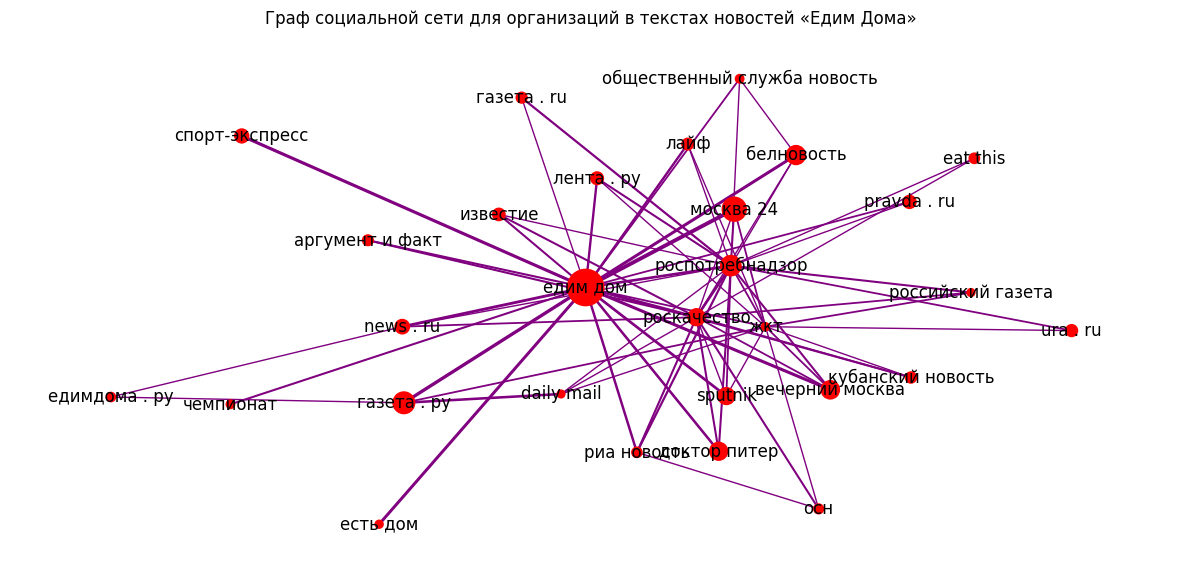

In [110]:
# отрисовываем граф
title = 'Граф социальной сети для организаций в текстах новостей «Едим Дома»'
draw_graph(G, organizations, connect_n, title)


## Метрики

Расчёт меры посредничества для вершин графа.

In [111]:
# расчет меры посредничества для каждой вершины в графе
bc = nx.betweenness_centrality(G)
bc


{'осн': 0.0011757789535567311,
 'риа новость': 0.00692869740488788,
 'роскачество': 0.14707734945830184,
 'жкт': 0.09987402368354749,
 'газета . ru': 0.0,
 'роспотребнадзор': 0.2433589485176787,
 'едим дом': 0.4172566557487193,
 'доктор питер': 0.0,
 'кубанский новость': 0.0002939447383891828,
 'российский газета': 0.0002939447383891828,
 'аргумент и факт': 0.0,
 'вечерний москва': 0.0002939447383891828,
 'белновость': 0.0012597631645250692,
 'известие': 0.0,
 'москва 24': 0.0002939447383891828,
 'daily mail': 0.0035567313345091123,
 'eat this': 0.0,
 'news . ru': 0.04135802469135802,
 'sputnik': 0.0002939447383891828,
 'pravda . ru': 0.0,
 'лайф': 0.0,
 'общественный служба новость': 0.0,
 'спорт-экспресс': 0.0,
 'газета . ру': 0.030070546737213405,
 'лента . ру': 0.0,
 'чемпионат': 0.0,
 'есть дом': 0.0,
 'ura . ru': 0.0,
 'едимдома . ру': 0.0013227513227513227}

Топ-10 вершин с самой большой мерой посредничества.

In [112]:
# топ-10 вершин с самой большой мерой посредничества
highest_bc = [v for v in sorted(bc, key=lambda v : bc[v], reverse=True)]

highest_bc[:10]


['едим дом',
 'роспотребнадзор',
 'роскачество',
 'жкт',
 'news . ru',
 'газета . ру',
 'риа новость',
 'daily mail',
 'едимдома . ру',
 'белновость']

## Творческая часть?

Давайте посмотрим, какие организации находятся друг от друга дальше всего и на каком расстоянии.

Для этого мы воспользуемся функцией ```shortest_path``` из библиотеки NetworkX и посчитаем кратчайшее расстояние между всеми возможными парами вершин и найдем среди них максимальное.

Функция для нахождения самых «длинных» коротких путей в графе.

In [113]:
def find_shortest_path(
    Graph: nx.classes.graph.Graph
) -> typing.List[typing.List[str]]:
    # дефолтная длина пути
    max_length = 1
    # список путей с длиной max_length
    paths = []

    # перебор всех вершин-организаций в графе
    for u in G.nodes():
        for v in G.nodes():
            if u != v:
                # поиск самого короткого пути между вершинами
                path = nx.shortest_path(Graph, u, v)
                if len(path) > max_length:
                    max_length = len(path)
                    paths = [path]
                elif len(path) == max_length:
                    paths.append(path)

    # возвращаем максимальную длину пути и список путей с такой длиной
    return max_length - 1, paths


In [114]:
max_length, paths = find_shortest_path(G)


Выберем случайный путь из списка и подкрасим его вершины и ребра в нашем графе в другой цвет (вершины в желтый, а ребра в красный).

In [115]:
idx = random.randint(0, len(paths) - 1)


In [116]:
# список ребер, которые необходимо подкрасить в графе
path_edges = [(paths[idx][i], paths[idx][i + 1]) for i in range(0, len(paths[idx]) - 1)]


In [117]:
# присваиваем каждой вершине цвет
node_colors = []

for node in G.nodes():
    # если текущая вершина есть на пути, то красим ее в желтый
    if node in paths[idx]:
        node_colors.append("yellow")
    # иначе -- дефолтный красный
    else:
        node_colors.append("red")


In [118]:
# присваиваем каждому ребру цвет
edge_colors = []

for edge in G.edges():
    # если текущее ребро есть на пути, то красим его в красный
    if edge in path_edges or edge[::-1] in path_edges:
        edge_colors.append("red")
    # иначе -- дефолтный фиолетовый
    else:
        edge_colors.append("purple")


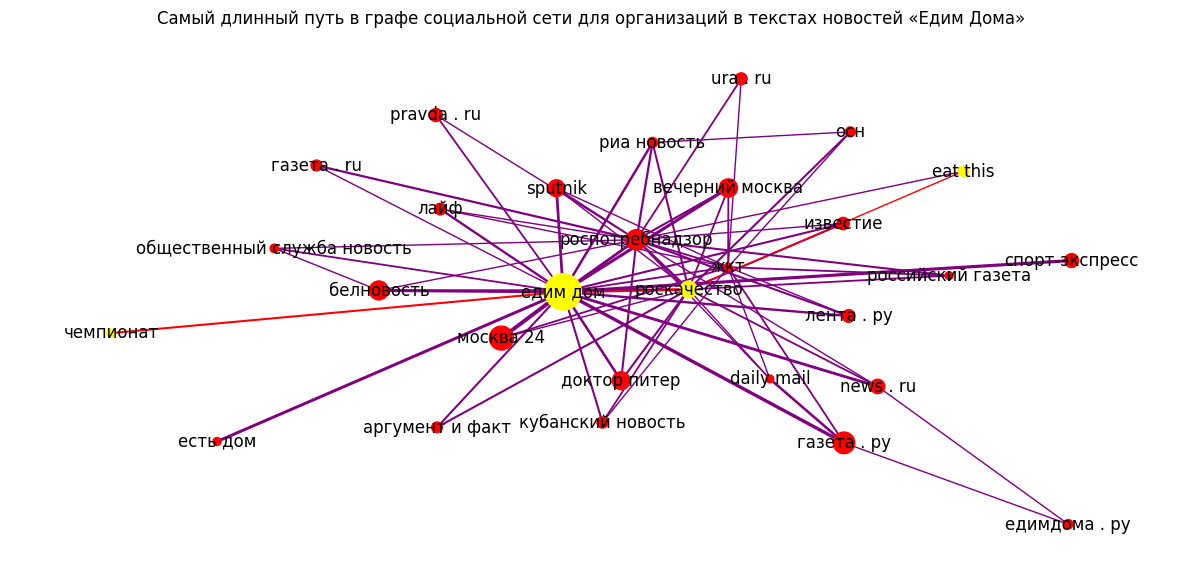

In [119]:
# отрисовываем граф
title = "Самый длинный путь в графе социальной сети для организаций в текстах новостей «Едим Дома»"
draw_graph(G, organizations, connect_n, title, node_colors, edge_colors)
